# Imports | Reads | Filter Patients

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_squared_log_error, r2_score

In [2]:
# Read MIMICs CSV file
mimic_df = pd.read_csv("CSV\\exports\\final\\mimic_mean_final.csv")

# Read eICUs CSV file
eicu_df = pd.read_csv("CSV\\exports\\final\\eicu_mean_final.csv")

In [3]:
day = 10

# Filter icu stay less than 10 days
mimic_df = mimic_df[mimic_df['los'] < day]

# Filter icu stay less than 10 days
eicu_df = eicu_df[eicu_df['los'] < day]

In [4]:
# Filter Time Zone

#time_zone = 16
#mimic_df = mimic_df[mimic_df['Time_Zone'] == time_zone]
#eicu_df = eicu_df[eicu_df['Time_Zone'] == time_zone]

In [5]:
"""
I'm gonna concat and split the mimic and icu
at this point. I must create the same columns
from the tranformation of categorical data.
"""
row_count = mimic_df.shape[0]
print(f"Row count: {row_count}")

Row count: 48992


In [6]:
# Concat dataframes
df_combined = pd.concat([mimic_df, eicu_df], ignore_index=True)

# Find all categorical columns in mimic
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_combined, columns=categorical_columns)

# Split the concatenate dataframe
mimic_df = df_encoded.iloc[:row_count, :]
eicu_df = df_encoded.iloc[row_count:, :]

In [7]:
display(mimic_df)

,row_count,subject_id,hadm_id,Time_Zone,age,Base Excess,Lactate,pCO2,Calculated Total CO2,BUN,...,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN
0,1,10004733,27411876,1,51,0.0,0.80,38.0,26.0,44.0,...,False,False,False,False,True,False,False,False,False,False
1,2,10004733,27411876,2,51,0.0,0.75,38.0,26.0,44.0,...,False,False,False,False,True,False,False,False,False,False
2,3,10004733,27411876,3,51,0.0,0.80,38.0,26.0,44.0,...,False,False,False,False,True,False,False,False,False,False
3,4,10004733,27411876,4,51,0.0,0.75,38.0,26.0,44.0,...,False,False,False,False,True,False,False,False,False,False
4,5,10004733,27411876,5,51,0.0,0.75,38.0,26.0,44.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48987,55788,19999987,23865745,12,57,1.0,NaN,44.0,28.0,18.0,...,False,False,False,False,True,False,False,False,False,False
48988,55789,19999987,23865745,13,57,1.0,NaN,44.0,28.0,18.0,...,False,False,False,False,True,False,False,False,False,False
48989,55790,19999987,23865745,14,57,1.0,NaN,44.0,28.0,18.0,...,False,False,False,False,True,False,False,False,False,False
48990,55791,19999987,23865745,15,57,1.0,NaN,44.0,28.0,18.0,...,False,False,False,False,True,False,False,False,False,False


In [8]:
total_test_val_perc = 0.2
split_between_test_val_perc = 0.5

# Group data by subject_id and hadm_id
grouped_df = mimic_df.groupby(['subject_id', 'hadm_id'])

# Get a new dataframe with one row per patient (subject_id, hadm_id) pair
patient_df = grouped_df['hospital_expire_flag'].first().reset_index()

# Split the patient_df into training (80%), validation (10%), and test (10%) while keeping the ratio of hospital_expired_flag
train, temp = train_test_split(patient_df, test_size=total_test_val_perc, stratify=patient_df['hospital_expire_flag'], random_state=42)
val, test = train_test_split(temp, test_size=split_between_test_val_perc, stratify=temp['hospital_expire_flag'], random_state=42)

# Step 4: Merge back with the original df to get the rows for each patient in the splits
train_df = mimic_df.merge(train[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
val_df = mimic_df.merge(val[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
test_df = mimic_df.merge(test[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Check the sizes of the splits
print(f'Training set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

Training set size: 39184
Validation set size: 4896
Test set size: 4912


# Check ratio and unique patients between sets

In [9]:
# Count on Training set survive and non-survive
survival_counts = train_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'Train Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = val_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nValidation Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = test_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nTest Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

Train Set
Survive: 1949.0
Non-survive: 500.0
Ratio Train Set: 3.90:1

Validation Set
Survive: 244.0
Non-survive: 62.0
Ratio Train Set: 3.94:1

Test Set
Survive: 244.0
Non-survive: 63.0
Ratio Train Set: 3.87:1


In [10]:
# Mine unique subject_id from sets
train_subjects = set(train_df['subject_id'].unique())
val_subjects = set(val_df['subject_id'].unique())
test_subjects = set(test_df['subject_id'].unique())

# Check if there are overlaping subject_id
train_val_overlap = train_subjects.intersection(val_subjects)
train_test_overlap = train_subjects.intersection(test_subjects)
val_test_overlap = val_subjects.intersection(test_subjects)

# Display the results
print(f'Overlap between training and validation sets: {len(train_val_overlap)}')
print(f'Overlap between training and test sets: {len(train_test_overlap)}')
print(f'Overlap between validation and test sets: {len(val_test_overlap)}')

# print overlaping
if train_val_overlap:
    print(f'Subjects in both training and validation: {train_val_overlap}')
if train_test_overlap:
    print(f'Subjects in both training and test: {train_test_overlap}')
if val_test_overlap:
    print(f'Subjects in both validation and test: {val_test_overlap}')


Overlap between training and validation sets: 0
Overlap between training and test sets: 0
Overlap between validation and test sets: 0


# Prepare Train - Validation - Test Sets

In [11]:
# External validation from eICU
X_external = eicu_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_external = eicu_df['los']

# Separate features and target for the training, validation, and test sets
X_train = train_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_train = train_df['los']

X_validate = val_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_validate = val_df['los']

X_test = test_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_test = test_df['los']

In [12]:
display (X_train)

,age,Base Excess,Lactate,pCO2,Calculated Total CO2,BUN,pH,pO2,Alanine Aminotransferase (ALT),Alkaline Phosphatase,...,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN
0,51,0.0,0.80,38.0,26.0,44.0,7.43,100.0,46.0,113.0,...,False,False,False,False,True,False,False,False,False,False
1,51,0.0,0.75,38.0,26.0,44.0,7.43,100.0,46.0,113.0,...,False,False,False,False,True,False,False,False,False,False
2,51,0.0,0.80,38.0,26.0,44.0,7.43,100.0,46.0,113.0,...,False,False,False,False,True,False,False,False,False,False
3,51,0.0,0.75,38.0,26.0,44.0,7.43,100.0,46.0,113.0,...,False,False,False,False,True,False,False,False,False,False
4,51,0.0,0.75,38.0,26.0,44.0,7.43,100.0,46.0,113.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39179,57,1.0,NaN,44.0,28.0,18.0,7.39,114.0,63.0,106.0,...,False,False,False,False,True,False,False,False,False,False
39180,57,1.0,NaN,44.0,28.0,18.0,7.39,114.0,63.0,106.0,...,False,False,False,False,True,False,False,False,False,False
39181,57,1.0,NaN,44.0,28.0,18.0,7.39,114.0,63.0,106.0,...,False,False,False,False,True,False,False,False,False,False
39182,57,1.0,NaN,44.0,28.0,18.0,7.39,114.0,63.0,106.0,...,False,False,False,False,True,False,False,False,False,False


# Train Model without HP

In [13]:
# Default XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Train Model with HP RandomizedSearchCV

In [ ]:
# Define the hyperparameter distributions
param_dist = {
    'learning_rate': np.arange(0.01, 1.01, 0.1),
    'max_depth': np.arange(1, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1),
    'n_estimators': [100, 200, 300]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV with tqdm integration
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                    param_distributions=param_dist, 
                                    n_iter=100,  # Number of random samples to try
                                    scoring='neg_mean_squared_error',  # Use negative MSE for minimization
                                    cv=2,  # Number of folds for cross-validation
                                    n_jobs=-1,  # Use all available cores
                                    verbose=1,  # Print progress
                                    random_state=42)  # Set seed for reproducibility

# Perform the RandomizedSearchCV
with tqdm(total=100, desc="Hyperparameter Tuning") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(100)

# Retrieve the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best hyperparameters: {best_params}")
print(f"Best validation MSE: {best_score}")

# Predict on the test set with the best model
y_pred_test = best_model.predict(X_test)

# Predict on the external validation set with the best model
y_pred_external = best_model.predict(X_external)

# Evaluation on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test) * 100

print(f"Test Set MSE: {mse_test}")
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R2 Score: {r2_test}")

# Evaluation on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set R2 Score: {r2_external}")

# Train Model with HP gridsearchcv

In [ ]:
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# Define the hyperparameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 1.01, 0.3),
    'max_depth': np.arange(1, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1),
    'n_estimators': [100, 200, 300]  # Keep n_estimators as is
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV with tqdm integration
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Use negative MSE for minimization
                           cv=2,  # Number of folds for cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=1)  # Disable default verbosity

# Perform the GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best hyperparameters: {best_params}")
print(f"Best validation MSE: {best_score}")

# Predict on the test set with the best model
y_pred_test = best_model.predict(X_test)

# Predict on the external validation set with the best model
y_pred_external = best_model.predict(X_external)

# Evaluation on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test) * 100

print(f"Test Set MSE: {mse_test}")
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R2 Score: {r2_test}")

# Evaluation on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
rmse_external = root_mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set R2 Score: {r2_external}")

# Test Set Plots

Test Set MSE: 3.4539215719049383
Test Set MAE: 1.320824226293457
Test Set RMSE: 1.858472913955148
Test Set R2: 35.504511559121774


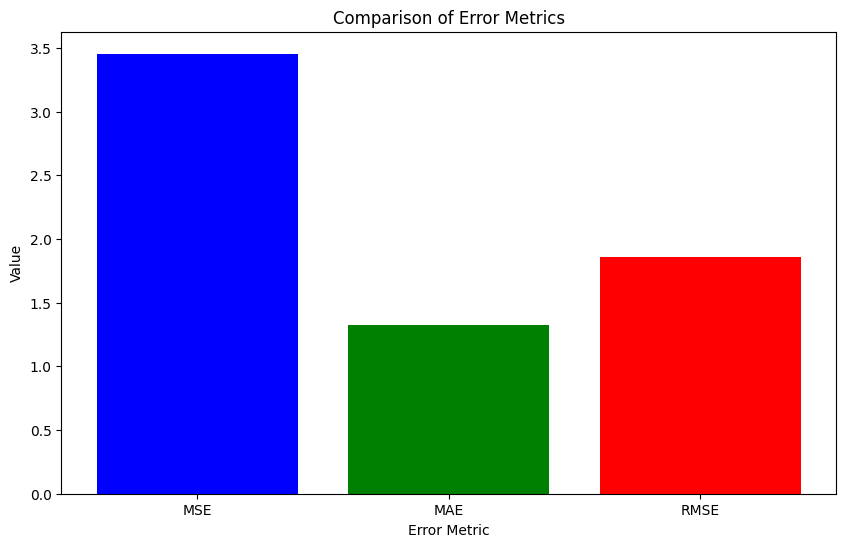

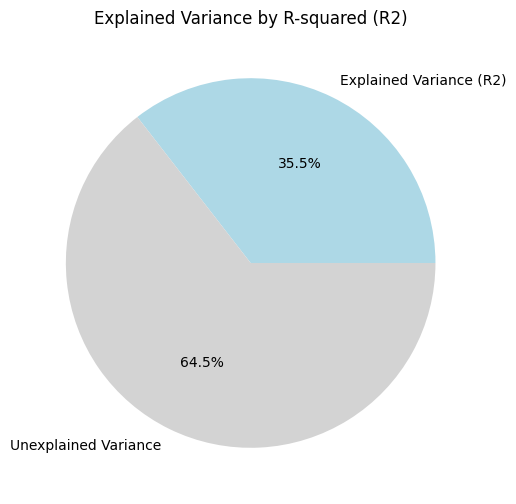

NameError: name 'msle_values' is not defined

<Figure size 1000x600 with 0 Axes>

In [14]:
# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) * 100

print(f"Test Set MSE: {mse}")
print(f"Test Set MAE: {mae}")
print(f"Test Set RMSE: {rmse}")
print(f"Test Set R2: {r2}")

# Plotting error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red'])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')
plt.show()

# Plotting R-squared (R2)
plt.figure(figsize=(6, 6))
plt.pie([r2, 100 - r2], labels=['Explained Variance (R2)', 'Unexplained Variance'], colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
plt.title('Explained Variance by R-squared (R2)')
plt.show()

# Plotting MSLE if applicable
try:
    msle = mean_squared_log_error(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(msle_values, marker='o', linestyle='-')
    plt.xlabel('Prediction')
    plt.ylabel('MSLE')
    plt.title('Mean Squared Logarithmic Error Across Predictions')
    plt.grid(True)
    plt.show()
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# External Validation Plots

External Validation Set MSE: 6.305134923669753
External Validation Set MAE: 1.734541544135144
External Validation Set RMSE: 2.5110027725332666
External Validation Set R2: -31.61094357901497


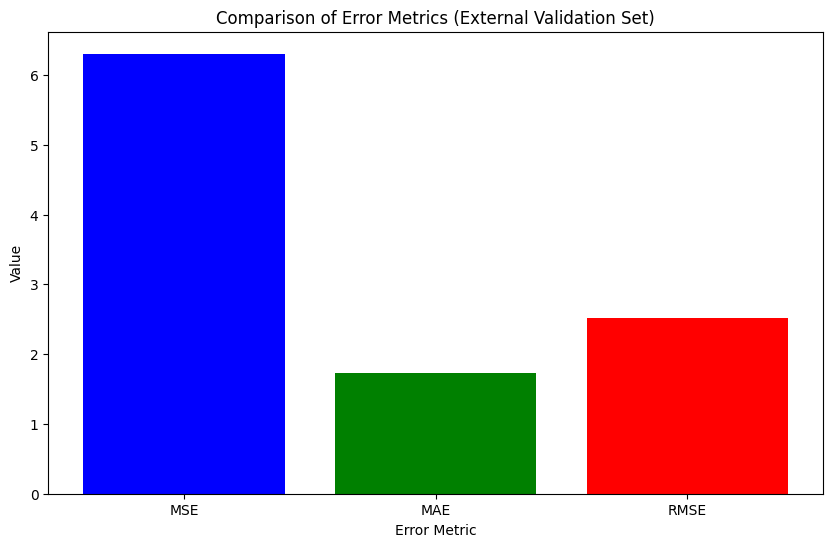

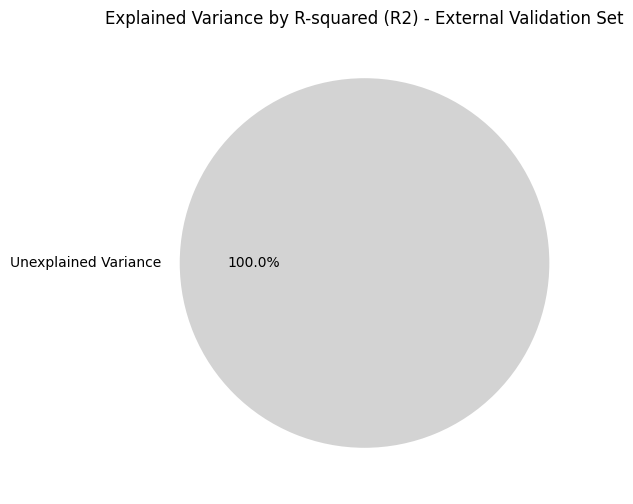

Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


In [15]:
# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set R2: {r2_external}")

# Plotting error metrics for the external validation set
error_metrics_external = ['MSE', 'MAE', 'RMSE']
values_external = [mse_external, mae_external, rmse_external]

plt.figure(figsize=(10, 6))
plt.bar(error_metrics_external, values_external, color=['blue', 'green', 'red'])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics (External Validation Set)')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Explained Variance by R-squared (R2) - External Validation Set')
plt.show()

# Plotting MSLE for the external validation set if applicable
try:
    msle_external = mean_squared_log_error(y_external, y_pred_external)
    plt.figure(figsize=(10, 6))
    plt.plot(y_external, y_pred_external, marker='o', linestyle='-', label='MSLE')
    plt.xlabel('Prediction')
    plt.ylabel('MSLE')
    plt.title('Mean Squared Logarithmic Error (MSLE) - External Validation Set')
    plt.grid(True)
    plt.show()
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Most important features

In [16]:
# Get feature importances
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Scale the importance
most_important_df['Importance'] *= 100000

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                     Feature    Importance
6                                         pH  10348.095000
4                       Calculated Total CO2   6472.067535
70                               Haptoglobin   4663.404077
46                                   Albumin   3946.385905
53       Arterial Blood Pressure mean (mmHg)   3280.891851
54                          Serum Osmolality   2893.896028
64              Reticulocyte Count Automated   2492.519654
82                                race_ASIAN   2366.410382
58                  C Reactive Protein (CRP)   2272.367477
52  Arterial Blood Pressure diastolic (mmHg)   1942.939125
42                                Pain Level   1897.171512
71                          Bilirubin Direct   1648.152620
67                       Differential-Lymphs   1618.940569
39                       Calcium non-ionized   1617.449522
48                           Total Bilirubin   1565.608568
59                      

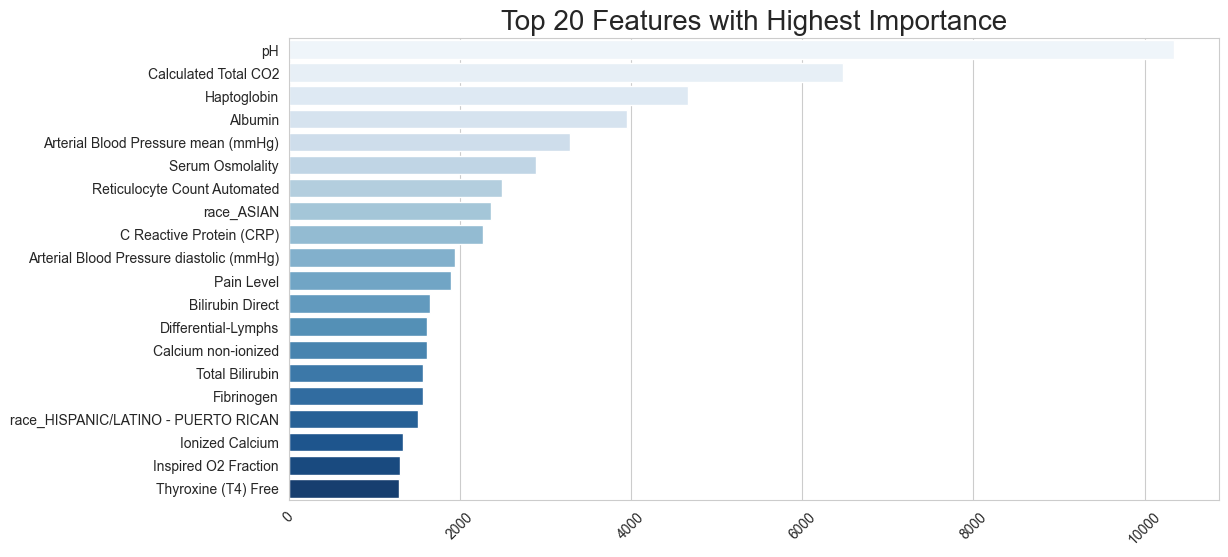

In [17]:
# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 10 most important features
top_10_features = most_important_df.head(20)

# Plotting
plt.figure(figsize=(12, 6))  # Reduce figure size
plot = sns.barplot(x='Importance', y='Feature', data=top_10_features, hue='Feature', palette="Blues", legend=False)

# Reduce font size slightly 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.title('Top 20 Features with Highest Importance', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.ylabel('')
plt.xlabel('')

# Save the plot in high resolution
#plt.savefig('plots/top_20_most_important_features.jpeg', dpi=300)
plt.show()

# Testing field

In [ ]:
# Define hyperparameter distributions
param_grid = {
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'max_depth': np.arange(1, 11),
    'min_child_weight': np.arange(1, 6),
    'reg_lambda': np.linspace(0.1, 15, 15),
    'reg_alpha': np.linspace(0.1, 15, 15),
    'n_estimators': [100, 200, 300]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV with tqdm integration
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Use negative MSE for minimization
                           cv=2,  # Number of folds for cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=1)  # Disable default verbosity

# Perform the GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best validation MSE: {best_score}")

# Predict and evaluate
y_pred_test = best_model.predict(X_test)
y_pred_external = best_model.predict(X_external)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test) * 100

print(f"Test Set MSE: {mse_test}")
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R2 Score: {r2_test}")

mse_external = mean_squared_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set R2 Score: {r2_external}")